# Task 3: Forecasting TSLA (6–12 months) using saved LSTM (TF) + MC-dropout CIs

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# imports
import os, json, pickle, math, time, pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from pandas.tseries.offsets import BDay


In [3]:
pd.set_option("display.float_format", lambda x: f"{x:,.6f}")
plt.rcParams["figure.figsize"] = (11,4)
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# prices.csv from Task 1
CANDIDATE_DIRS = ["/content/drive/MyDrive/preprocessed_data"]

def find_file(name):
    for d in CANDIDATE_DIRS:
        p = os.path.join(d, name)
        if os.path.exists(p):
            return p
    raise FileNotFoundError(f"Could not find {name} under {CANDIDATE_DIRS}")

prices_path = find_file("prices.csv")
meta_path   = os.path.join(os.path.dirname(prices_path), "meta.json")

close = pd.read_csv(prices_path, parse_dates=["Date"]).set_index("Date").sort_index()
meta = {}
if os.path.exists(meta_path):
    with open(meta_path) as f: meta = json.load(f)

assert "TSLA" in close.columns, "TSLA column not found in prices.csv"

print("Loaded:", prices_path)
print("Window:", close.index.min().date(), "→", close.index.max().date(), "rows:", len(close))
display(close.tail())


Loaded: /content/drive/MyDrive/preprocessed_data/prices.csv
Window: 2015-07-01 → 2025-07-31 rows: 2632


,BND,SPY,TSLA
Date,,,
2025-07-25,73.120000,637.100000,316.060000
2025-07-28,73.000000,636.940000,325.590000
2025-07-29,73.380000,635.260000,321.200000
2025-07-30,73.190000,634.460000,319.040000
2025-07-31,73.200000,632.080000,308.270000


# Load LSTM (TF) + scaler

In [5]:
import pickle
from tensorflow import keras

MODEL_KERAS = "/content/drive/MyDrive/models/tsla_lstm_tf.keras"
SCALER_PKL  = "/content/drive/MyDrive/models/tsla_scaler.pkl"
# load scaler
with open(SCALER_PKL, "rb") as f:
    scaler = pickle.load(f)

# load TF LSTM model (.keras)
model = keras.models.load_model(MODEL_KERAS)

print(" Loaded:", MODEL_KERAS, "and", SCALER_PKL)
# model.summary()  # optional


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


 Loaded: /content/drive/MyDrive/models/tsla_lstm_tf.keras and /content/drive/MyDrive/models/tsla_scaler.pkl


# Forecast helpers (deterministic + MC-dropout)

In [6]:
def business_days_after(last_date, n):
    start = last_date + BDay(1)
    return pd.date_range(start, periods=n, freq="B")

def lstm_rollout_tf(model, scaler, history_series, lookback=60, steps=252, training=False):
    """
    Iteratively forecast `steps` business days ahead.
    If training=True, Dropout layers stay active (MC-dropout sampling).
    """
    vals = history_series.values.astype("float32").reshape(-1,1)
    scaled = scaler.transform(vals)
    window = scaled[-lookback:].copy()
    preds_scaled = []
    for _ in range(steps):
        x = np.expand_dims(window, 0)                 # (1, lookback, 1)
        yhat = model(x, training=training).numpy()[0,0]  # training toggles dropout
        preds_scaled.append(yhat)
        window = np.vstack([window[1:], [[yhat]]])
    preds_scaled = np.array(preds_scaled).reshape(-1,1)
    preds = scaler.inverse_transform(preds_scaled).ravel()
    idx = business_days_after(history_series.index[-1], steps)
    return pd.Series(preds, index=idx, name="forecast")

def lstm_mc_dropout_bands(model, scaler, history_series, lookback=60, steps=252, n_sims=200, q=(2.5, 97.5)):
    sims = []
    for _ in range(n_sims):
        fc = lstm_rollout_tf(model, scaler, history_series, lookback, steps, training=True)
        sims.append(fc.values)
    sims = np.vstack(sims)                     # (n_sims, steps)
    lo, hi = np.percentile(sims, q, axis=0)
    idx = business_days_after(history_series.index[-1], steps)
    bands = pd.DataFrame({"lower": lo, "upper": hi}, index=idx)
    mean_path = pd.Series(sims.mean(axis=0), index=idx, name="mean")
    return mean_path, bands, sims


# Make 6- and 12-month forecasts with CIs

In [7]:
# Parameters
LOOKBACK = 60
STEPS_6M = 126      # ~6 months of business days
STEPS_12M = 252     # ~12 months

tsla_hist = close["TSLA"].astype(float)
last_date = tsla_hist.index[-1]

# Deterministic paths (dropout disabled)
fc_6m_det  = lstm_rollout_tf(model, scaler, tsla_hist, lookback=LOOKBACK, steps=STEPS_6M, training=False)
fc_12m_det = lstm_rollout_tf(model, scaler, tsla_hist, lookback=LOOKBACK, steps=STEPS_12M, training=False)

# MC-dropout bands (95% CI by default)
mean_6m, band_6m, sims_6m   = lstm_mc_dropout_bands(model, scaler, tsla_hist, lookback=LOOKBACK, steps=STEPS_6M,  n_sims=200, q=(2.5, 97.5))
mean_12m, band_12m, sims_12m = lstm_mc_dropout_bands(model, scaler, tsla_hist, lookback=LOOKBACK, steps=STEPS_12M, n_sims=200, q=(2.5, 97.5))

print("Last observed date:", last_date.date())
print("6m forecast range:", fc_6m_det.index.min().date(), "→", fc_6m_det.index.max().date())
print("12m forecast range:", fc_12m_det.index.min().date(), "→", fc_12m_det.index.max().date())


Last observed date: 2025-07-31
6m forecast range: 2025-08-01 → 2026-01-23
12m forecast range: 2025-08-01 → 2026-07-20


# Plots (history + forecast + bands)

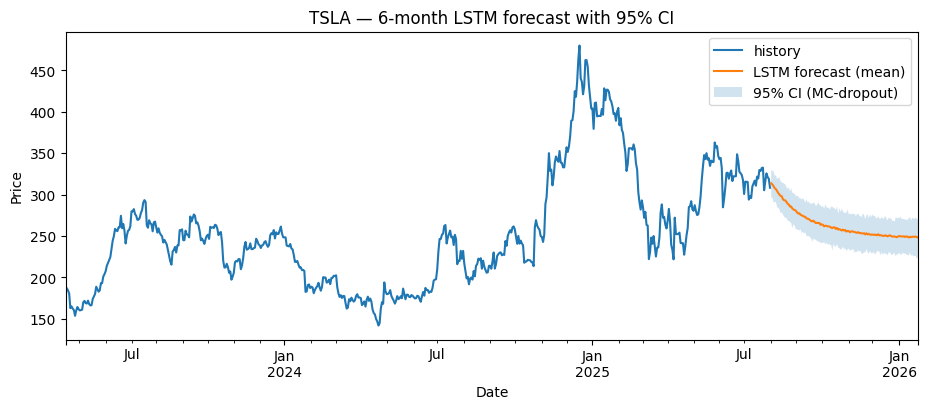

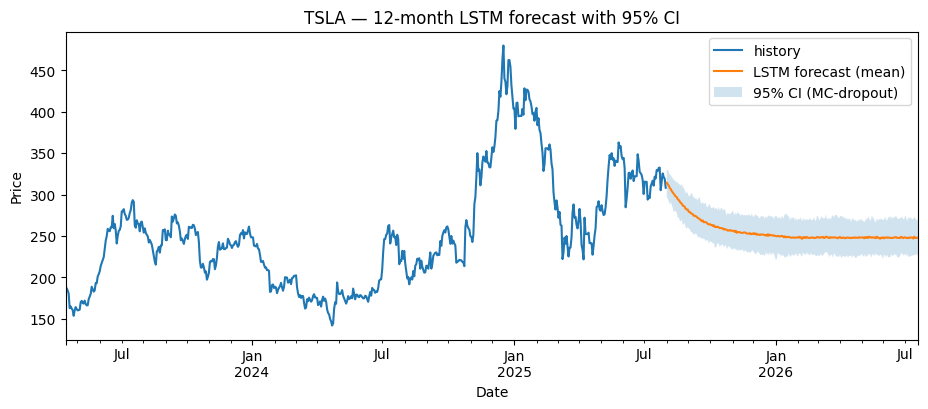

In [8]:
def plot_forecast(hist, fc_mean, bands, title, hist_tail_days=600):
    plt.figure(figsize=(11,4))
    hist.tail(hist_tail_days).plot(label="history")
    fc_mean.plot(label="LSTM forecast (mean)")
    plt.fill_between(bands.index, bands["lower"], bands["upper"], alpha=0.2, label="95% CI (MC-dropout)")
    plt.title(title); plt.legend(); plt.xlabel("Date"); plt.ylabel("Price"); plt.show()

plot_forecast(tsla_hist, mean_6m,  band_6m,  "TSLA — 6-month LSTM forecast with 95% CI")
plot_forecast(tsla_hist, mean_12m, band_12m, "TSLA — 12-month LSTM forecast with 95% CI")


# Analytics: trend, uncertainty growth, simple returns

In [9]:
def summarize(fc_mean, bands, last_price):
    exp_end = fc_mean.iloc[-1]
    exp_ret = (exp_end / last_price) - 1.0
    # CI width growth over horizon
    width_start = (bands["upper"].iloc[0] - bands["lower"].iloc[0])
    width_end   = (bands["upper"].iloc[-1] - bands["lower"].iloc[-1])
    return {
        "expected_end_price": float(exp_end),
        "expected_return_pct": float(exp_ret * 100),
        "ci_width_start": float(width_start),
        "ci_width_end": float(width_end),
        "ci_widening_factor": float(width_end / max(width_start, 1e-9)),
    }

last_price = tsla_hist.iloc[-1]
s6  = summarize(mean_6m,  band_6m,  last_price)
s12 = summarize(mean_12m, band_12m, last_price)

print("Last price:", round(last_price, 2))
print("6m expected end price:", round(s6["expected_end_price"], 2),
      "| exp. return:", f'{s6["expected_return_pct"]:.2f}%')
print("12m expected end price:", round(s12["expected_end_price"], 2),
      "| exp. return:", f'{s12["expected_return_pct"]:.2f}%')
print("CI widening (6m):", f'{s6["ci_widening_factor"]:.2f}×',
      "| start:", round(s6["ci_width_start"],2), "end:", round(s6["ci_width_end"],2))
print("CI widening (12m):", f'{s12["ci_widening_factor"]:.2f}×',
      "| start:", round(s12["ci_width_start"],2), "end:", round(s12["ci_width_end"],2))


Last price: 308.27
6m expected end price: 248.26 | exp. return: -19.47%
12m expected end price: 247.87 | exp. return: -19.59%
CI widening (6m): 1.33× | start: 33.6 end: 44.8
CI widening (12m): 1.30× | start: 31.95 end: 41.62


# Save forecast series locally (not required to commit)

In [11]:
save_dir = "/content/drive/MyDrive/preprocessed_data"
os.makedirs(save_dir, exist_ok=True)

# 3) Save CSVs (requires mean_6m, band_6m, mean_12m, band_12m already computed)
mean_6m.to_csv(os.path.join(save_dir, "tsla_lstm_mean_6m.csv"))
band_6m.to_csv(os.path.join(save_dir, "tsla_lstm_bands_6m.csv"))
mean_12m.to_csv(os.path.join(save_dir, "tsla_lstm_mean_12m.csv"))
band_12m.to_csv(os.path.join(save_dir, "tsla_lstm_bands_12m.csv"))

print(" Saved CSVs to:", save_dir)

 Saved CSVs to: /content/drive/MyDrive/preprocessed_data
